<a href="https://colab.research.google.com/github/mrrkdas/mrrkdas/blob/main/Transfer_Learning_with_Food101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Tensorflow imports 
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# Other Import
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Getting the data
train_data = tfds.load('food101', split = 'train', as_supervised = True)
test_data = tfds.load('food101', split = 'validation', as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete61HNQ9/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete61HNQ9/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Getting to know the data

In [3]:
classes = ['apple_pie','baby_back_ribs','baklava','beef_carpacci','beef_tartare','beet_salad','beignets','bibimbap','bread_pudding','breakfast_burrito','bruschetta',
'caesar_salad','cannoli','caprese_salad','carrot_cake','ceviche','cheesecake','cheese_plate','chicken_curry','chicken_quesadilla','chicken_wings','chocolate_cake','chocolate_mousse','churros','clam_chowder',
'club_sandwich','crab_cakes','creme_brulee','croque_madame','cup_cakes','deviled_eggs','donuts','dumplings','edamame','eggs_benedict','escargots','falafel','filet_mignon','fish_and_chips','foie_gras','french_fries',
'french_onion_soup','french_toast','fried_calamari','fried_rice','frozen_yogurt','garlic_bread','gnocchi','greek_salad','grilled_cheese_sandwich','grilled_salmon','guacamole','gyoza','hamburger','hot_and_sour_soup','hot_dog',
'huevos_rancheros','hummus','ice_cream','lasagna','lobster_bisque','lobster_roll_sandwich','macaroni_and_cheese','macarons','miso_soup','mussels','nachos','omelette', 'onion_rings', 'oysters','pad_thai', 'paella',
'pancakes', 'panna_cotta', 'peking_duck', 'pho', 'pizza', 'pork_chop', 'poutine', 'prime_rib', 'pulled_pork_sandwich', 'ramen', 'ravioli', 'red_velvet_cake', 'risotto', 'samosa',
'sashimi', 'scallops', 'seaweed_salad', 'shrimp_and_grits', 'spaghetti_bolognese', 'spaghetti_carbonara', 'spring_rolls', 'steak', 'strawberry_shortcake', 'sushi', 'tacos', 'takoyaki', 'tiramisu', 'tuna_tartare', 'waffles']

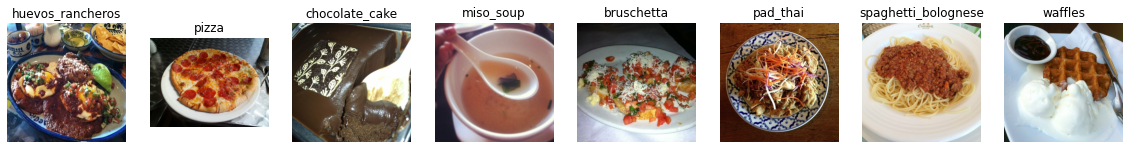

In [4]:
i = 0
fig, ax = plt.subplots(1, 8, figsize = (20, 20))
for image, label in train_data.take(8): 
    ax[i].axis('off')
    ax[i].set_title(classes[label])
    ax[i].imshow(image)
    i += 1
 
plt.show()

## Preprocessing

In [5]:
def preprocess_images(img, label, height = 480, width = 480): 
  """ This function resizes the images, and return the label along with the image

  Parameters:
      height: the height to reisize the image
      width: the width to resize the image """ 

  image  = tf.image.resize(img, [height, width]) / 255 # Resizing and making the image standardized

  # Data Augementation
  data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    # tf.keras.layers.RandomCrop(height = 3, width = 5), changes the shape
    tf.keras.layers.RandomZoom(0.4)
  ])

  image = data_augmentation(image)


  return image, label

In [6]:
# Defining Height and Width
HEIGHT = 480
WIDTH = 480

In [7]:
train_data = train_data.map(preprocess_images).batch(128).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(preprocess_images).batch(128).prefetch(tf.data.AUTOTUNE)

## Model using efficient_net_v2 L

In [8]:
efficientnet_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/classification/2'

In [9]:
fine_tuning = False

In [10]:
feature_extractor_layer = hub.KerasLayer(efficientnet_url, trainable = fine_tuning, input_shape = (HEIGHT, WIDTH) + (3,), name = 'feature_extractor_layer')

In [11]:
# Adding the output layer to the model
efficientnet_model = tf.keras.Sequential([
                                          feature_extractor_layer,
                                          tf.keras.layers.Dense(101, activation = 'softmax', name = 'output_layer'),
                                          #name = 'efficientnet_model' 
                                          ], name = 'efficientnet_model')

In [12]:
# Compiling the model
efficientnet_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['sparse_categorical_accuracy'])

In [13]:
# Calbacks 

# Learning Rate Scheduler
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Early Stopping
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor = 'val_loss', min_delta = 0.3, patience = 3)

In [ ]:
efficientnet_history = efficientnet_model.fit(train_data, epochs = 20, validation_data = test_data, callbacks = [lr_scheduler, es_callback])

 55/592 [=>............................] - ETA: 2:40:20 - loss: 3.8383 - sparse_categorical_accuracy: 0.1763

## After Model

In [ ]:
def plot_metrics(history, accuracy = 'accuracy', validation_accuracy = 'val_accuracy'):
  """ Plots loss, and accuracy. 

  Parameter:

    history: model.fit()
    accuracy: the type of accuracy (could vary for sum situations)
    validation_accuracy: type of validation accuracy (could vary for some situations) """

  plt.plot(history.history['loss'], label = "Loss")
  plt.plot(history.history['val_loss'], label = 'Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss Vs. Epochs')
  plt.legend()
  plt.show()

  plt.plot(history.history[accuracy], label = "Accuracy")
  plt.plot(history.history[validation_accuracy], label = 'Validation Accuracy')
  plt.xlabel('Epcohs')
  plt.ylabel('Accuracy')
  plt.title('Accuracy Vs. Epochs')
  plt.legend()
  plt.show()

In [ ]:
plot_metrics(efficientnet_history, accuracy = 'sparse_categorical_accuracy', validation_accuracy = 'val_sparse_categorical_accuracy')

In [ ]:
# Evaluate
efficientnet_results = efficientnet_model.evaluate(test_data)

In [ ]:
# Predictions
preds = efficientnet_model.predict(test_data)

In [ ]:
preds = np.round_(preds)

In [ ]:
test_data_unbatched = test_data.unbatch()

In [ ]:
images = []
labels = []

for image, label in test_data_unbatched:
  images.append(image)
  labels.append(label)

In [ ]:
preds

In [ ]:
plt.imshow(images[1])
plt.title(classes[preds[1].argmax()])
plt.axis('off')
plt.show()

In [ ]:
i = 0
fig, ax = plt.subplots(1, 8, figsize = (20, 20))
for image, label in test_data_unbatched.take(8):
    ax[i].axis('off')
    ax[i].set_title(classes[preds[i].argmax()])
    ax[i].imshow(image)
    i += 1
 
plt.show()

In [ ]:
# Saving and loading the model
efficientnet_model.save('food101_model')

In [ ]:
new_model = tf.keras.models.load_model('food101_model')
new_preds = new_model.predict(test_data)

In [ ]:
i = 0
fig, ax = plt.subplots(1, 8, figsize = (20, 20))
for image, label in test_data_unbatched.take(8):
    ax[i].axis('off')
    ax[i].set_title(classes[new_preds[i].argmax()])
    ax[i].imshow(image)
    i += 1
 
plt.show()

In [ ]:
# Predict on an image from the internet
image = '/content/pizza_pic.jpeg'
image  = tf.image.resize(image, [480, 480]) / 255

In [ ]:
plt.title(classes[int(np.round_(efficientnet_model.predict(image)))])
plt.imshow(image)